In [1]:
# import data
import numpy as np
import json

# Change .json filename to select animal ID number

# import standard experiment data (XS) and metadata (S_labels)
with open('data/pyData/2705_Data_S_Notch14_1.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XS = pxx.reshape(a*b, c).T
S_labels = data[1]

sID = {'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}
y = {'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}

# Train data ONLY on standard experiments from day 1: X, S_labels where subject contains 1
# stimON = 1 vs nonstim = 0 (baseline AND stimOFF)
for k in range(0, len(S_labels['allWindows']['subject'])):
    d = S_labels['allWindows']['subject'][k][6]
    sID[d].append(k)
    y[d].append(int(S_labels['allWindows']['stimOn'][k]))
    
X = XS[sID['1']]
X_all = XS

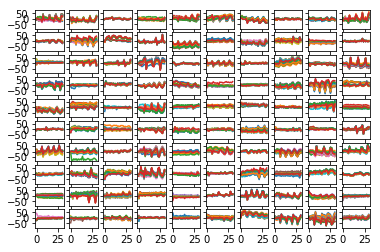

In [2]:
# convert data into frequency (scores) and component profiles (factors) from ICA

from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

C = 100 # number of features    
ica = FastICA(n_components = C, max_iter = 5000,tol = 0.0001) #tol = 0.001
scores = ica.fit_transform(X_all) #pull components from ica fit transformation

yClass = []
scoreClass = np.zeros((0, 100))
trainingDays = 9
for i in range(0, trainingDays):
    scoreClass = np.concatenate((scoreClass, scores[sID[str(i+1)]]), axis = 0)
    yClass.extend(y[str(i+1)])
    
factors = ica.mixing_
factors = factors.reshape(a, b, C)

I = 10
J = 10

f0, ax = plt.subplots(I, J, sharex = True, sharey = True) #Build a better subplot matrix
for i in range(0, I):
    for j in range(0, J):
        if i*I+j < factors.shape[2]:
            ax[i, j].plot(S_labels['f'], factors[:, :, i*I+j])

plt.show()

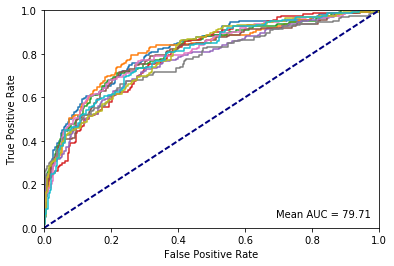

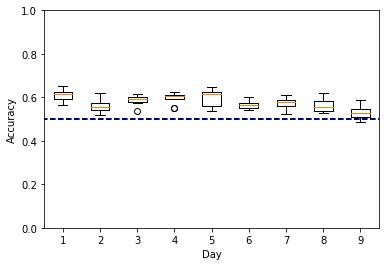

In [3]:
# (1) split scores and labels into training and testing groups
# (2) plot data as boxplots, and difference of the weights between neuron and muscle

from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.metrics import roc_curve, auc

n = 10 # number of folds
F = 1 # number of sets of folds
testAcc = np.zeros((F, n))
fpr = dict()
tpr = dict()
roc_auc = []
s0 = plt.figure()
s1 = plt.figure()

for fld in range(0,F):
    i = 0
    d_auc = np.zeros((n, 9))
    skf = StratifiedKFold(n_splits = n, shuffle = True)    
    for train_index, test_index in skf.split(scoreClass, yClass):
        X_train, X_test = scoreClass[train_index], scoreClass[test_index]
        y_train, y_test = np.array(yClass)[train_index], np.array(yClass)[test_index]
        clf = svm.SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
        y_score = clf.fit(X_train, y_train).decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc.append(auc(fpr, tpr))
        plt.figure(s0.number)
        plt.plot(fpr, tpr, lw = 1.5)
        
        plt.figure(s1.number)
        for d in range(0, 9):
            y_score = clf.fit(scores[sID[str(d+1)]], y[str(d+1)]).decision_function(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_score)
            d_auc[i, d] = auc(fpr, tpr)
        i = i + 1
    
    plt.boxplot(d_auc)
    plt.plot([0, 10], [0.5, 0.5], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.5, 9.5])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Day')
    plt.ylabel('Accuracy')
    
    plt.figure(s0.number)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(0.975, 0.05, 'Mean AUC = %0.2f' % (np.mean(roc_auc)*100), horizontalalignment = 'right')
    
    plt.show()
    
s0.savefig('dayVariabilityOutput/ROC_' + str(trainingDays) + '.jpg')
s1.savefig('dayVariabilityOutput/boxPlot_' + str(trainingDays) + '.jpg')